<a href="https://colab.research.google.com/github/darwinpadilla/darwinpadilla/blob/main/Calidad_de_vino.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Actualizacion

In [ ]:
#Actualizamos statsmodels porque seaborn lo necesita
!pip install --upgrade statsmodels

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.7/dist-packages (0.12.2)


# Librerias

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn import tree
from sklearn.base import clone
from subprocess import check_call
import PIL

pd.set_option("display.max_columns", 50)

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

# Data de los Vinos

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df = pd.read_csv("drive/My Drive/doctorado/wine.csv")

In [ ]:
!ls

drive  sample_data  tree1.dot  tree1.png


In [ ]:
# Veamos los datos del Archivo
train_data = pd.read_csv('drive/My Drive/doctorado/wine.csv')

In [ ]:
#Tamaño del dataset
train_data.shape

(4898, 12)

In [ ]:
#Vemos los primeros registros del dataset
train_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


## Pre-procesamiento del dataset

In [ ]:
train_data.dtypes

fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object

In [ ]:
train_data["quality"].min(), train_data["quality"].max()

(3, 9)

In [ ]:
train_data.groupby('quality').size()

quality
3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
dtype: int64

# Train-validation split

In [ ]:
#Separamos la data, en variables independientes (x) y dependientes (y), para poder entrenar un árbol de clasificación
x = train_data.drop("quality", axis=1)

y = train_data["quality"]

In [ ]:
#Mediante el método "train_test_split" usaremos el 20% de la data para probar el modelo. El parámetro "random state" nos sirve para
#poder replicar la misma separación
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
print(f"Train shape: {x_train.shape}")
print(f"Test shape: {x_test.shape}")

Train shape: (3918, 11)
Test shape: (980, 11)


# Analicemos la data para el árbol

In [ ]:
x_train.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
count,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000,3918.000000
mean,6.865046,0.279338,0.332731,6.450702,0.045734,35.094564,138.001149,0.994071,3.189293,0.489781,10.508840
std,0.844483,0.101606,0.119758,5.139311,0.021797,16.676958,42.067667,0.003022,0.150183,0.113590,1.227887
min,3.800000,0.080000,0.000000,0.600000,0.009000,3.000000,10.000000,0.987110,2.720000,0.220000,8.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991740,3.090000,0.410000,9.500000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,33.000000,134.000000,0.993800,3.180000,0.470000,10.400000
75%,7.300000,0.330000,0.380000,10.000000,0.050000,46.000000,167.000000,0.996200,3.280000,0.550000,11.400000
max,11.800000,1.100000,1.660000,65.800000,0.346000,146.500000,313.000000,1.038980,3.820000,1.080000,14.200000


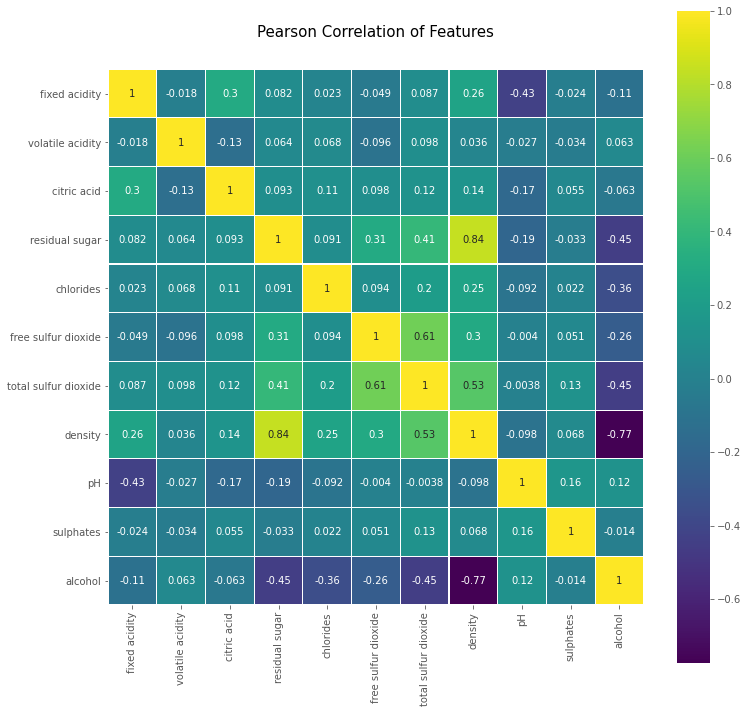

In [ ]:
colormap = plt.cm.viridis
plt.figure(figsize=(12,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)

sns.heatmap(x_train.astype(float).corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

# Dividir los vinos en tres categorías: malos (de 0 a 4) regulares (de 5 a 7) y buenos (de 8 a 10)


In [ ]:
#train_data['Calidad']=train_data['quality']
x_train.dtypes
print(x_train)

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
4665            7.3              0.17         0.36            8.20      0.028   
1943            6.3              0.25         0.44           11.60      0.041   
3399            5.6              0.32         0.33            7.40      0.037   
843             6.9              0.19         0.35            1.70      0.036   
2580            7.7              0.30         0.26           18.95      0.053   
...             ...               ...          ...             ...        ...   
4426            6.2              0.21         0.52            6.50      0.047   
466             7.0              0.14         0.32            9.00      0.039   
3092            7.6              0.27         0.52            3.20      0.043   
3772            6.3              0.24         0.29           13.70      0.035   
860             8.1              0.27         0.35            1.70      0.030   

      free sulfur dioxide  

In [ ]:
#Cambiar las categorias

y_trainj = np.copy(y_train)

print(y_trainj)
y_train_f=[]
n=0

for Cate in y_trainj:
  if Cate<=4:
    y_train_f.append(1)
  elif Cate>4 and Cate<8:
    y_train_f.append(2)
  else:
    y_train_f.append(3)
  n=n+1

print(y_train_f)

[6 5 6 ... 6 6 8]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 

In [ ]:
print(x_train)
print(y_train)
#print(y_train.groupby('quality').size())

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
4665            7.3              0.17         0.36            8.20      0.028   
1943            6.3              0.25         0.44           11.60      0.041   
3399            5.6              0.32         0.33            7.40      0.037   
843             6.9              0.19         0.35            1.70      0.036   
2580            7.7              0.30         0.26           18.95      0.053   
...             ...               ...          ...             ...        ...   
4426            6.2              0.21         0.52            6.50      0.047   
466             7.0              0.14         0.32            9.00      0.039   
3092            7.6              0.27         0.52            3.20      0.043   
3772            6.3              0.24         0.29           13.70      0.035   
860             8.1              0.27         0.35            1.70      0.030   

      free sulfur dioxide  

# Categorización de Datos QUALITY entre malos, regulares y buenos

In [ ]:
# Crear arrays de entrenamiento y las etiquetas
y_train_ff=np.array(y_train_f).reshape(3918,)
#print(y_train_ff)
#print(x_train)
# Crear Arbol de decision con profundidad = 4
decision_tree = tree.DecisionTreeClassifier(criterion='entropy',splitter='best',min_samples_split=180,min_samples_leaf=5,max_depth =4)
decision_tree.fit(x_train, y_train_ff)
print("El arbol predice:")
data_p9=np.array([[9.1,0.27,0.45,10.6,0.035,28,124,0.997,3.2,0.46,10.4]])
data_p3=np.array([[8.5,0.26,0.21,16.2,0.074,41,197,0.998,3.02,0.5,9.8]])
decision_tree.predict(data_p3)

# exportar el modelo a archivo .dot
with open(r"tree2.dot", 'w') as f:
  f = tree.export_graphviz(decision_tree,out_file=f,max_depth =7,impurity = True,feature_names = list(x_train),class_names = ['Malo','Bueno'],rounded = True,filled= True )

# Convertir el archivo .dot a png para poder visualizarlo

check_call(['dot','-Tpng',r'tree2.dot','-o',r'tree2.png'])
#PImage("tree1.png")
PIL.Image.open("tree2.png")


El arbol predice:


array([2])